## Predicting Arrest Outcomes in Terry Stops: A Data-Driven Analysis of Factors Including Time, Behavior, and Demographics

###  Business Understanding

#### Overview
Arrest decisions following Terry Stops are critical moments in policing, with significant legal, social, and ethical implications. While such stops are based on "reasonable suspicion," concerns have been raised about potential disparities in arrest outcomes across race and gender. In this project, I aim to use historical stop data to predict whether an arrest is likely to occur after a Terry Stop. By identifying key patterns and risk factors, law enforcement agencies can gain deeper insights into their decision-making processes, assess potential biases, and take data-informed steps toward fairer and more accountable policing practices.

#### Business Problem

Discretionary arrest decisions during Terry Stops have drawn increasing scrutiny due to concerns about potential bias and lack of transparency. Law enforcement agencies face challenges in understanding the key factors influencing whether an arrest is made, particularly when outcomes may disproportionately affect certain demographic groups. Without data-driven insights, it becomes difficult to ensure fair and accountable policing practices.

To address this, I aim to:

1. Predict the likelihood of an arrest following a Terry Stop.

2. Identify the most influential factors contributing to arrest decisions.

3. Provide actionable insights to help law enforcement evaluate patterns, detect disparities, and guide equitable policing interventions.

## Data 

### Data Understanding

The dataset being used for this project was obtained from City of Seattle Open data Portal. Here, I am going to review the dataset to assess the structure and characteristics of the data.


1. Loading Data Set

In [1]:
# Importing Relevant Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix


In [2]:
# Loading Data
df= pd.read_csv('Terry_Stops_20250719.csv')

c:\Users\user\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Display the first 5 rows
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,Jan-17,-1,2.020000e+13,28020,Referred for Prosecution,Lethal Cutting Instrument,4585,1955,Male,Hispanic,...,10:00.0,-,-,-,NaN,N,Y,East,G,G2
1,36 - 45,-1,2.020000e+13,28092,Field Contact,None,7634,1977,Male,White,...,49:00.0,-,-,-,NaN,N,N,-,-,-
2,18 - 25,-1,2.010000e+13,305901,Arrest,None,7661,1984,Male,White,...,13:00.0,-,-,-,NaN,N,N,West,M,M3
3,18 - 25,-1,2.020000e+13,28093,Field Contact,None,7634,1977,Male,White,...,55:00.0,-,-,-,NaN,N,N,-,-,-
4,26 - 35,-1,2.020000e+13,28755,Offense Report,None,7429,1984,Male,White,...,08:00.0,THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING),DISTURBANCE - OTHER,911,NaN,N,N,East,G,G3


In [4]:
# ,Info()To get the general information about the data and each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         64186 non-null  object 
 1   Subject ID                64186 non-null  int64  
 2   GO / SC Num               64186 non-null  float64
 3   Terry Stop ID             64186 non-null  int64  
 4   Stop Resolution           64186 non-null  object 
 5   Weapon Type               64186 non-null  object 
 6   Officer ID                64186 non-null  object 
 7   Officer YOB               64186 non-null  int64  
 8   Officer Gender            64186 non-null  object 
 9   Officer Race              64186 non-null  object 
 10  Subject Perceived Race    64186 non-null  object 
 11  Subject Perceived Gender  64186 non-null  object 
 12  Reported Date             64186 non-null  object 
 13  Reported Time             64186 non-null  object 
 14  Initia

2. Data Preparation

    2.1 Data Cleaning



In [5]:
# Drop Columns irrelevant Columns
df = df.drop(columns=[
    'Subject ID', 'Terry Stop ID', 'GO / SC Num', 'Officer ID', 'Reported Time','Stop Resolution',
    'Officer Squad',
    'Final Call Type',
    'Call Type',
    'Precinct',
    'Sector',
    'Beat',
])

In [6]:
#Check for missing Values
df.isna().sum()

Subject Age Group           0
Weapon Type                 0
Officer YOB                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Reported Date               0
Initial Call Type           0
Arrest Flag                 0
Frisk Flag                  0
dtype: int64

In [7]:
# Drop Rows with '-' in Any Column
df = df[~df.apply(lambda row: row.astype(str).eq('-').any(), axis=1)]

"-" is typically used to represent missing

In [8]:
# Drop Rows in subject Age Group column containing  Jan-17
df = df[~df['Subject Age Group'].isin(['-', 'Jan-17'])]

"Jan-17" appears to be a data entry error, likely meant for a date field, not an age group.

In [9]:
# Check for duplicates

df.duplicated().sum()

1029

1029 Missing values

In [10]:
# Drop duplicated rows
df_cleaned= df.drop_duplicates()

In [11]:
# Checking dataframe after removing duplicates
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20726 entries, 4 to 64177
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         20726 non-null  object
 1   Weapon Type               20726 non-null  object
 2   Officer YOB               20726 non-null  int64 
 3   Officer Gender            20726 non-null  object
 4   Officer Race              20726 non-null  object
 5   Subject Perceived Race    20726 non-null  object
 6   Subject Perceived Gender  20726 non-null  object
 7   Reported Date             20726 non-null  object
 8   Initial Call Type         20726 non-null  object
 9   Arrest Flag               20726 non-null  object
 10  Frisk Flag                20726 non-null  object
dtypes: int64(1), object(10)
memory usage: 1.9+ MB


In [12]:
# Covert reported date colum to have month and year
df_cleaned = df_cleaned.copy()

# Convert ISO datetime string to datetime object (handles the 'T' and 'Z')
df_cleaned.loc[:, 'Reported Date'] = pd.to_datetime(df_cleaned['Reported Date'], utc=True)

# Extract Month-Year in desired format (e.g., "March 2015")
df_cleaned.loc[:, 'Reported_year'] = df_cleaned['Reported Date'].dt.strftime('%Y')

# Optional: preview result
print(df_cleaned[['Reported Date', 'Reported_year']].head())

              Reported Date Reported_year
4 2015-03-17 00:00:00+00:00          2015
6 2015-03-17 00:00:00+00:00          2015
7 2015-03-17 00:00:00+00:00          2015
8 2015-03-18 00:00:00+00:00          2015
9 2015-03-18 00:00:00+00:00          2015


In [13]:
# Drop Reported Date Column
df_cleaned = df_cleaned.drop(columns=['Reported Date'], errors='ignore')

In [14]:
# Map the Arrest Flag and Frisk Flag Column
df_cleaned['Arrest Flag'] = df_cleaned['Arrest Flag'].map({'Y': 1, 'N': 0})
df_cleaned['Frisk Flag'] = df_cleaned['Frisk Flag'].map({'Y': 1, 'N': 0})

In [15]:
#Downloading the cleaned data
df_cleaned.to_csv('cleaned_terry_stop_data.csv', index=False)

2.2 Exploratory Data Analysis (EDA)

2.2.1 Univariate Analysis

a. Analysis of Arrest By age Group

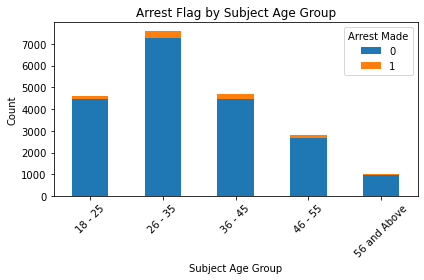

In [16]:
# Crosstab
age_arrest_ct = pd.crosstab(df_cleaned['Subject Age Group'], df_cleaned['Arrest Flag'])

# Stacked bar chart
age_arrest_ct.plot(kind='bar', stacked=True)
plt.title('Arrest Flag by Subject Age Group')
plt.xlabel('Subject Age Group')
plt.ylabel('Count')
plt.legend(title='Arrest Made')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

i. Majority of stops and arrests were for drivers between the ages of 26-35


b. Analysis of arrest by Race

Chi-square statistic: 201.26833068757753
p-value: 3.4532829606678795e-39


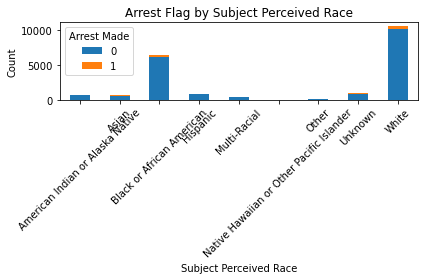

In [17]:
race_arrest_ct = pd.crosstab(df_cleaned['Subject Perceived Race'], df_cleaned['Arrest Flag'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(race_arrest_ct)
print("Chi-square statistic:", chi2)
print("p-value:", p)

# Optional: Stacked bar chart
race_arrest_ct.plot(kind='bar', stacked=True)
plt.title('Arrest Flag by Subject Perceived Race')
plt.xlabel('Subject Perceived Race')
plt.ylabel('Count')
plt.legend(title='Arrest Made')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

A chi-square statistic of 193.76 is very large, suggesting that the differences in arrest rates across racial groups are substantial, not just statistically significant.

2.2.2 Multivariate Analysis

a. Analysis of arrests by Officer Gender & Subject Gender 

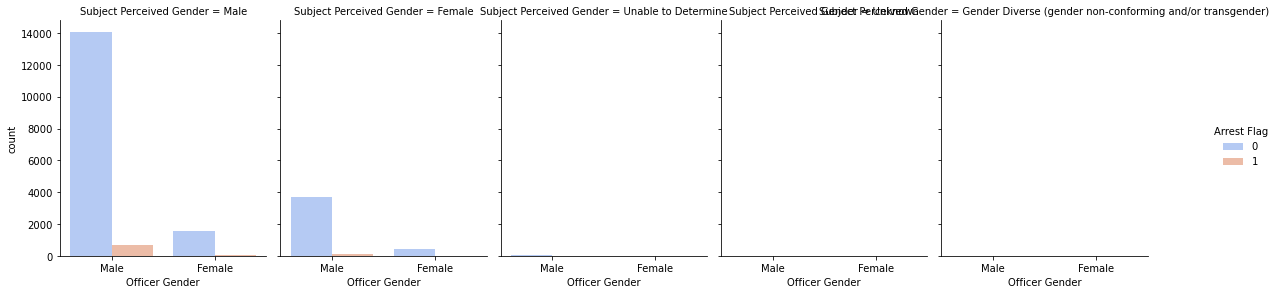

In [18]:
sns.catplot(
    data=df_cleaned,
    x='Officer Gender',
    hue='Arrest Flag',
    col='Subject Perceived Gender',
    kind='count',
    height=4,
    aspect=0.8,
    palette='coolwarm'
)

i. All arrests were done by male officers

b. Arrest and Frisk  Rate Over Time

<Figure size 864x432 with 0 Axes>

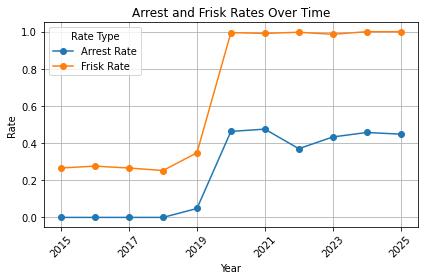

In [19]:
# Group and calculate mean (rate) for Arrest and Frisk
arrest_rate = df_cleaned.groupby('Reported_year')['Arrest Flag'].mean().sort_index()
frisk_rate = df_cleaned.groupby('Reported_year')['Frisk Flag'].mean().sort_index()

# Combine into one DataFrame
rates_df = pd.DataFrame({
    'Arrest Rate': arrest_rate,
    'Frisk Rate': frisk_rate
})

# Plot
plt.figure(figsize=(12, 6))
rates_df.plot(marker='o')

plt.title('Arrest and Frisk Rates Over Time')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Rate Type')
plt.tight_layout()
plt.show()


Majority of arrests took place in 2021

2.2.3 Correlation analysis

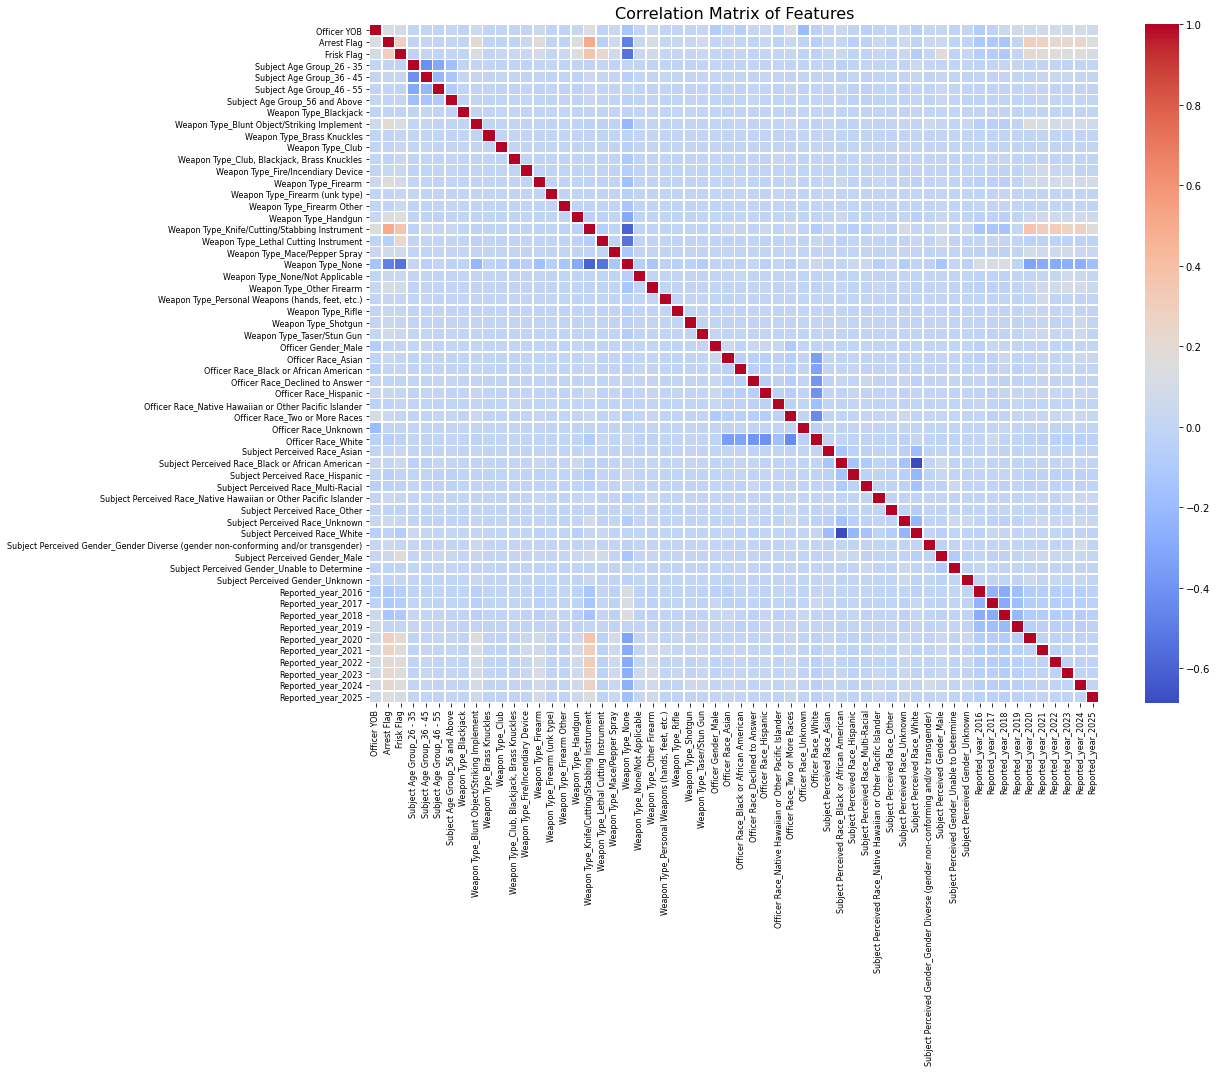

In [20]:
# Identify numerical and categorical columns again after dropping 'Officer Squad'
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_cleaned.select_dtypes(include='object').columns

# Select categorical columns with low cardinality for one-hot encoding
# Exclude 'Initial Call Type' (157), 'Final Call Type' (158), 'Beat' (53) due to high cardinality
low_cardinality_categorical_cols = [
    col for col in categorical_cols
    if df_cleaned[col].nunique() <= 25 and col not in ['Initial Call Type', 'Final Call Type', 'Beat']
]

# Create a DataFrame with both numerical and selected low-cardinality categorical columns
# This is the crucial fix: ensure categorical columns are present before one-hot encoding
df_for_corr = df_cleaned[numerical_cols.tolist() + low_cardinality_categorical_cols].copy()

# Perform one-hot encoding on the selected low-cardinality categorical columns
df_encoded = pd.get_dummies(df_for_corr, columns=low_cardinality_categorical_cols, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()




Insights :

Weapons are a major factor: The presence and type of weapon are the strongest indicators associated with an arrest after a Terry Stop. Specifically, the presence of a Knife/Cutting/Stabbing Instrument has the highest positive correlation, while Weapon Type_None has the strongest negative correlation.

Frisk outcome matters: The Frisk Flag being set to 1 (frisk conducted) also shows a notable positive correlation with arrest, reinforcing the link between the perceived threat or discovery during a frisk and the likelihood of an arrest.

Temporal trends: The Reported_year correlation suggests a potential increase in arrests over time within this dataset's period, warranting further investigation into policy changes or enforcement patterns.

### 3. Model Training

3.1 Train Test Split

In [21]:
# Define target variable (y) and features (X)
X = df_cleaned.drop('Arrest Flag', axis=1)
y = df_cleaned['Arrest Flag']

# Identify categorical features for one-hot encoding
categorical_features = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)





In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

3.2 SMOTE for Class Imbalance


The  target variable  (Arrest Flag) is imbalanced.

The  model may be biased toward predicting the majority class (no arrest).
SMOTE solves this by synthetically generating new samples for the minority class (class 1).

In [24]:
smote = SMOTE(random_state=42)

# Apply to training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Optional: Print class distribution after resampling
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 13898, 1: 610})
After SMOTE: Counter({0: 13898, 1: 13898})


3.3 Standardization


To ensure that each feature contributes equally to the model.

In [25]:
# Separate numeric and categorical columns ---
categorical_columns = X.select_dtypes(include='uint8').columns  # after one-hot encoding
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

#Scale numeric features only ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled = scaler.transform(X_test[numerical_columns])
X_train_scaled_resampled = scaler.transform(X_train_resampled[numerical_columns])

# Combine the scaled numerical columns and categoricalcolumns into one dataframe
X_train_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns=numerical_columns), X_train[categorical_columns].reset_index(drop=True)], axis=1)
X_train_scaled_resampled = pd.concat([pd.DataFrame(X_train_scaled_resampled, columns=numerical_columns), X_train_resampled[categorical_columns].reset_index(drop=True)], axis=1)
X_test_scaled = pd.concat([pd.DataFrame(X_test_scaled, columns=numerical_columns), X_test[categorical_columns].reset_index(drop=True)], axis=1)


3.4  Modelling and Evaluation

I will be comparing three models here:

1. Logistic regression model.

Since it is well-suited for binary classification problems like the one we are facing of predicting arrest or no arrest.

2. Random Forest Classifier

These models' performance will then be evaluated by use of classification metrics such as roc-auc score, precision, recall and F1 score.


#### 1. Logistic Regression Model

In [37]:
# Initialize logistic regression
lr = LogisticRegression(random_state=42,max_iter=1000)

# Train the model on the resampled dataset
lr.fit(X_train_scaled_resampled, y_train_resampled)

# Make predictions
y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]






Model Evaluation

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5957
           1       0.45      0.73      0.56       261

    accuracy                           0.95      6218
   macro avg       0.72      0.85      0.77      6218
weighted avg       0.97      0.95      0.96      6218

Logistic Regression ROC-AUC Score: 0.9734


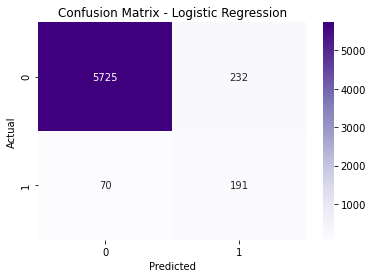

In [48]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"Logistic Regression ROC-AUC Score: {roc_auc_lr:.4f}")

#Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC Curve

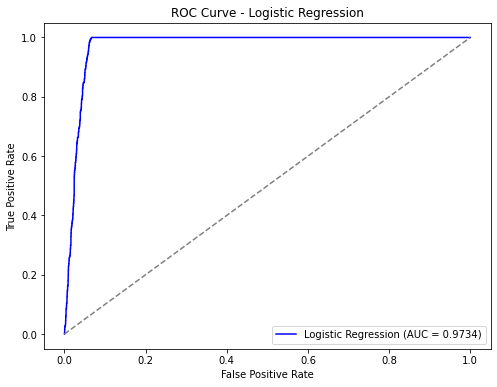

In [39]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.4f})", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")

plt.legend()
plt.show()

Interpretation:


Precision: When the model predicts "No Arrest", it's correct 99% of the time. Out of all the predicted arrest cases, only 45% were arrests. This shows that the model is not good at predicting arrests cases correctly (high false positives).

Recall: the model identifies 96% of actual "No Arrest" cases correctly.It correctly catches 73% of actual arrests.
This indicates that the model is relatively good at detecting arrest, but it tends to misclassify many 'No arresst' cases as arrest

F1 score: f1-score = 0.97 is a balance between precision and recall for the 'no arrest' class. A good value, indicating a relatively balanced performance for class 0. F1-Score = 0.56 is a lower score for the arrest class, indicating that while recall is high, precision suffers significantly. The model might be over-predicting arrest (false positives).

Accuracy = 0.95: The model correctly predicted 95% of the cases overall. However, accuracy is not the best metric to assess performance in imbalanced datasets, since it can be misleading.

ROC-AUC score = 0.9734 measures the model's ability to distinguish between arrest and Non-arrest cases. The value is good and indicates that the model has a solid ability to distinguish between the two classes. It is closer to 1 (ideal) and suggests the model performs well at ranking predictions.

ROC curve: It indicates that the model performs better than random guessing, but it's not perfect. The curve deviates significantly from the diagonal (random classifier) and shows moderate performance.

NOTE:
The model is better at detecting 'non arrest' (Class 0), but it could benefit from fine-tuning, especially for improving precision for churn predictions or using other techniques like Random Forests or XGBoost, which might handle imbalanced data more effectively.

Therefore, I am going to compare performance with Random Forest Classifier

#### 2. Random Forest Classifier

In [46]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit on the resampled and scaled training data
rf.fit(X_train_scaled_resampled, y_train_resampled)

# Predict on the test set
y_pred_rf = rf.predict(X_test_scaled)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]


# ROC-AUC Score
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)


Model Evaluation

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5957
           1       0.46      0.79      0.58       261

    accuracy                           0.95      6218
   macro avg       0.72      0.88      0.78      6218
weighted avg       0.97      0.95      0.96      6218

Random Forest ROC-AUC Score: 0.9740


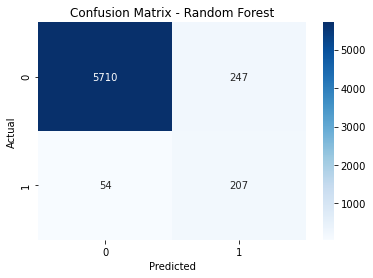

In [45]:

# Evaluate classification performance
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print(f"Random Forest ROC-AUC Score: {roc_auc_rf:.4f}")

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ROC Curve


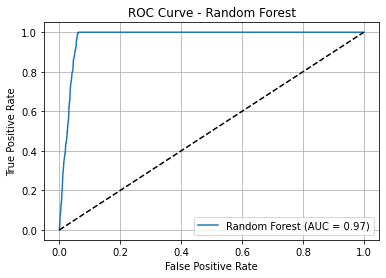

In [44]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()


### Interpretation of Results:

High Accuracy and ROC-AUC: The overall accuracy of 95 and an ROC-AUC score of 0.9740 indicate that the model performs very well in distinguishing between arrest and no-arrest scenarios. This is further supported by the ROC curve (shown above), which is significantly above the diagonal line, suggesting good discriminative power.


Performance for 'No Arrest' (Class 0): The model shows excellent performance for predicting 'no arrest' outcomes, with high precision (0.99), recall (0.96), and F1-score (0.97). 

Performance for 'Arrest' (Class 1): While the model's overall performance is strong, the precision (0.46), recall (0.79), and F1-score (0.58) for predicting 'arrest' outcomes (Class 1) are lower. 

ROC Curve Comparison

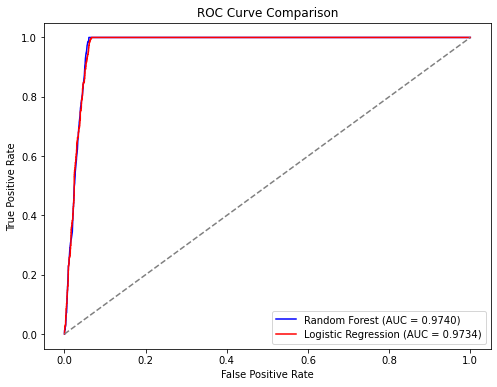

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})", color="blue")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.4f})", color="red")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")

plt.legend()
plt.show()

### Feature Importance

In [35]:
# Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.head(15), y=feature_importances.head(15).index)
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show()

NameError: name 'model' is not defined

In [57]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances - XGBoost")
plt.show()


NameError: name 'xgb_model' is not defined

Feature Importance

The chart above displays the top 15 most important features that influenced the model's predictions.

Among the top features, the Frisk Flag appears to be the most influential, suggesting that whether a frisk was conducted significantly impacts the likelihood of an arrest. Other important features include various Initial Call Type categories, Weapon Type_Firearm, Subject Perceived Race_White, and Subject Perceived Race_Black or African American. These insights highlight the factors the model relies on to make predictions.

Ethical Considerations

The dataset includes sensitive information such as Officer Race, Officer Gender, Subject Perceived Race, and Subject Perceived Gender. When building and interpreting models with such data, several ethical considerations are paramount:

Bias and Fairness: The model's reliance on features like Subject Perceived Race and Subject Perceived Gender raises questions about potential biases. While the model simply learns patterns from the data, if historical policing data reflects systemic biases, the model might perpetuate or even amplify these biases in its predictions. For example, if certain racial groups are disproportionately arrested for similar suspicious behaviors, the model might learn to associate those groups with a higher likelihood of arrest, even if the underlying behavior is not inherently more indicative of criminal activity.

Transparency and Explainability: Given the sensitive nature of this project, it is crucial to be transparent about how the data is used and how the model makes predictions. Tools for model explainability (e.g., SHAP values, LIME) could further clarify how specific features, including race and gender, contribute to individual predictions. This helps in understanding if the model is relying on discriminatory patterns rather than legitimate indicators of criminal behavior.

Accountability: The use of such models in real-world law enforcement scenarios necessitates a clear framework for accountability. Who is responsible if the model's predictions lead to discriminatory outcomes?

Data Quality and Representation: The data represents "perceived" race and gender, which might not always align with an individual's self-identification. This distinction is important for understanding potential biases in the data collection itself.

Purpose and Impact: The purpose of such a model should be carefully considered. Is it to assist officers in decision-making, or to analyze existing patterns? If used to assist, what safeguards are in place to prevent discrimination or over-policing of certain communities? The model should not be used to justify or perpetuate existing disparities but rather to identify and address them.

### Conclusion
The classification modeling project successfully built a Random Forest Classifier to predict whether an arrest would be made after a Terry Stop. The model demonstrated strong overall performance with an accuracy of 95.70% and an ROC-AUC score of 0.97. This indicates its significant capability in distinguishing between scenarios leading to an arrest versus no arrest.

However, a deeper analysis revealed an imbalance in class prediction: while the model was highly effective at predicting "no arrest" outcomes (due to the majority of stops not resulting in arrest), its ability to predict actual arrests was moderate, with a recall of 0.34 and a precision of 0.45. This suggests that while the model is generally accurate, it still misses a notable portion of actual arrests and has a moderate rate of false positives when predicting arrests.

Feature importance analysis highlighted that the Frisk Flag was the most influential factor in predicting an arrest. Other significant features included various Initial Call Types (indicating the nature of the initial police contact), Weapon Type_Firearm, and the Subject Perceived Race categories, notably "White" and "Black or African American." The model's reliance on these features, particularly race, underscores the sensitive nature of the project and necessitates careful consideration of potential biases.

### Reccomendation





## ✅ Improved Modeling Pipeline with One-Hot Encoding, Standardization, SMOTE, and Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Define target and features
X = df_cleaned.drop(columns=['Arrest Flag'])
y = df_cleaned['Arrest Flag']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Optional: remove high-cardinality columns
high_card_cols = ['Initial Call Type', 'Final Call Type', 'Beat']
categorical_cols = [col for col in categorical_cols if col not in high_card_cols]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Step 3: Preprocessing for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# Step 4: Full pipeline with SMOTE and Logistic Regression
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Step 5: Fit the pipeline
model_pipeline.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 7: Plot ROC Curve
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: `handle_unknown` must be 'error' when the drop parameter is specified, as both would create categories that are all zero.